In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Konfiguracja

In [2]:
all_filenames = {
    'daily': {
        'pzu': './pzu_01-06-2010_01-01_2015.csv',
        'pxm': './pxm_01-06-2010_01-01_2015.csv',
        'itg': './itg_01-06-2010_01-01_2015.csv'
    },
    'weekly': {
        'pzu': './pzu_01-06-2010_01-01_2015_weekly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_weekly.csv',
        'itg': './itg_01-06-2010_01-01_2015_weekly.csv'
    },
    'monthly': {
        'pzu': './pzu_01-06-2010_01-01_2015_monthly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_monthly.csv',
        'itg': './itg_01-06-2010_01-01_2015_monthly.csv'
    }
}

frequency = 'monthly'
filenames = all_filenames[frequency]
phase_col_name = 'Zamkniecie'
date_col_name = 'Data'
date_format = '%Y-%m-%d'
usecols = [date_col_name] + [phase_col_name]
dates = ['2010-06-01', '2012-01-01', '2013-01-01', '2014-01-01']

### Wczytywanie danych

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, date_format)

def csv_file_to_df(filename):
    assert(len(filename) > 0)
    df = pd.read_csv(filename, parse_dates=[date_col_name], date_parser=dateparse, usecols=usecols)
    return df.set_index(date_col_name)

In [4]:
data_frames = dict(((name, csv_file_to_df(filename)) for name, filename in filenames.items()))
assert(len(data_frames) == 3)
data_frames

{'itg':             Zamkniecie
 Data                  
 2010-06-30       71.00
 2010-07-30       76.50
 2010-08-31       65.80
 2010-09-30       71.00
 2010-10-29       74.60
 2010-11-30       79.75
 2010-12-31       79.70
 2011-01-31       78.00
 2011-02-28       80.95
 2011-03-31       84.10
 2011-04-29      107.00
 2011-05-31      118.90
 2011-06-30      118.00
 2011-07-29      110.40
 2011-08-31      104.90
 2011-09-30      103.90
 2011-10-31       98.80
 2011-11-30       99.00
 2011-12-30      114.40
 2012-01-31      128.50
 2012-02-29      137.30
 2012-03-30      152.90
 2012-04-30      138.00
 2012-05-31      133.40
 2012-06-29      141.00
 2012-07-31      134.00
 2012-08-31      127.70
 2012-09-28      137.60
 2012-10-31      160.50
 2012-11-30      169.40
 2012-12-31      184.50
 2013-01-31      189.70
 2013-02-28      179.90
 2013-03-29      188.00
 2013-04-30      197.00
 2013-05-31      252.50
 2013-06-28      264.00
 2013-07-31      315.00
 2013-08-30      287.00
 2013-09-

## Wykresy, przedział czasowy od 2010-06-01 do 2015-01-01

Wybrałem ten sam przedział dla wszystkich akcji, bo z jednej strony ułatwiło mi to analizę zmian ich wartość, a z drugiej wg tego, co wyczytałem w Sieci, na polskim rynku optymalnym jest najczęściej horyzont 3-5 razy dłuższy od długości planowanej inwestycji.

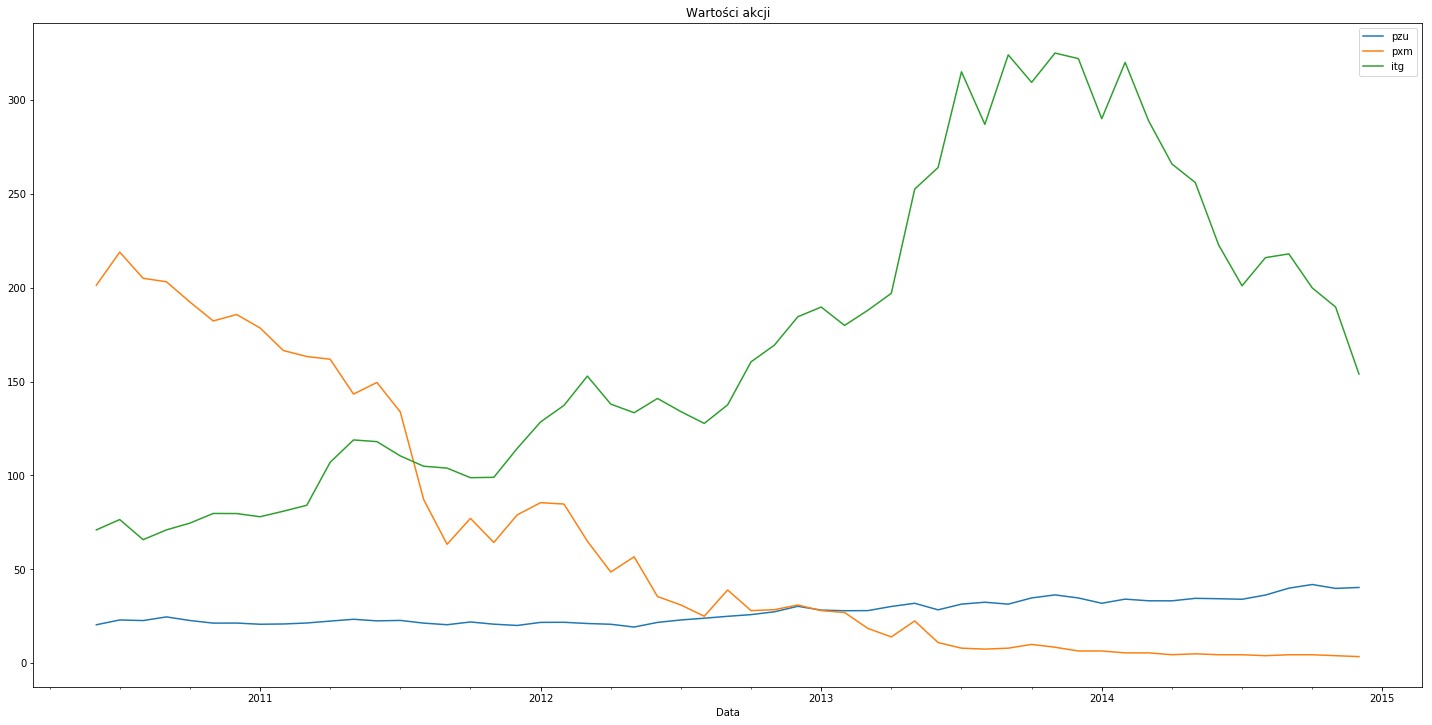

In [5]:
figsize = (20, 10)
kind = 'line'

def plot_data_frames(data_frames):
    for name, df in data_frames.items():
        df[phase_col_name].plot(kind=kind, figsize=figsize, label=name)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title("Wartości akcji")
    plt.show()
    

plot_data_frames(data_frames)

### Stopy zwrotu

In [6]:
dfs = {name: {'return': df.loc[df.index >= '2010-06-01'].pct_change()}  for name, df in data_frames.items()}
dfs
mixed_dfs = pd.concat({name: df['return'] for name, df in dfs.items()}, axis=1)
mixed_dfs.corr()

itg        pxm        pzu
               Zamkniecie Zamkniecie Zamkniecie
itg Zamkniecie   1.000000   0.184749   0.294264
pxm Zamkniecie   0.184749   1.000000   0.232355
pzu Zamkniecie   0.294264   0.232355   1.000000

### Wyliczenie parametrów

In [7]:
def get_correlation_matrix(data_frames, start_date):
    dfs = {name: {'return': df.pct_change()}  for name, df in data_frames.items()}
    mixed_dfs = pd.concat({name: df['return'].loc[df['return'].index >= start_date] for name, df in dfs.items()}, axis=1)
    return mixed_dfs.corr()

In [8]:
def calculate_parameters(data_frames, start_date):
    return {
        name: {
            'return': (1.0 + df.pct_change().loc[df.index >= start_date].mean()[0]) ** 12 - 1,
            'risk': df.pct_change().loc[df.index >= start_date].std()[0]
        }
        for name, df in data_frames.items()
    }

dates = ['2010-06-01', '2012-01-01', '2013-01-01', '2014-01-01']
parameters_per_date = {date: calculate_parameters(data_frames, date) for date in dates}
corr_matrices = {date: get_correlation_matrix(data_frames, date) for date in dates}

# Wykresy akcji na podstawie wyliczonych stóp zwrotu i ryzyk

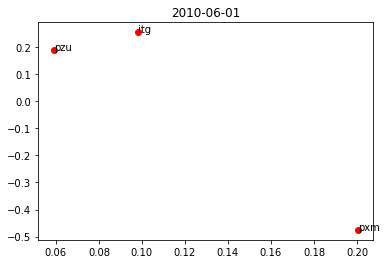

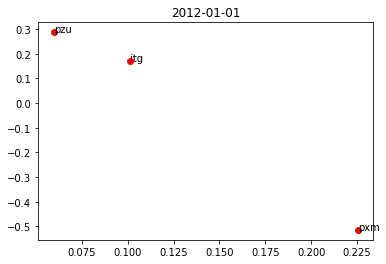

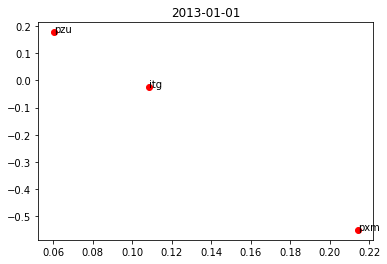

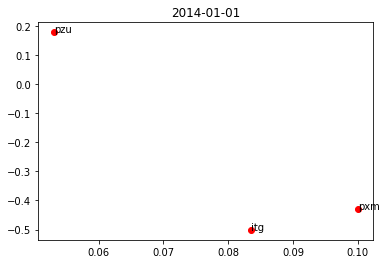

In [9]:
def plot_parameters(parameters_per_date, date):
    assert date in parameters_per_date
    parameters = parameters_per_date[date]
    fig, ax = plt.subplots()
    plt.title(date)
    for name, params in parameters.items():
        assert 'risk' in params
        assert 'return' in params
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name, (params['risk'], params['return']))
    plt.show()

for date in dates:
    plot_parameters(parameters_per_date, date)

### Macierz korelacji

In [10]:
corr_matrices

{'2010-06-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000   0.184749   0.294264
 pxm Zamkniecie   0.184749   1.000000   0.232355
 pzu Zamkniecie   0.294264   0.232355   1.000000,
 '2012-01-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000   0.155402   0.332990
 pxm Zamkniecie   0.155402   1.000000   0.189206
 pzu Zamkniecie   0.332990   0.189206   1.000000,
 '2013-01-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000   0.172277   0.304136
 pxm Zamkniecie   0.172277   1.000000   0.332422
 pzu Zamkniecie   0.304136   0.332422   1.000000,
 '2014-01-01':                       itg        pxm        pzu
                Zamkniecie Zamkniecie Zamkniecie
 itg Zamkniecie   1.000000  -0.013886   0.598547
 pxm Zamkniecie  -0.013886   1.000000   0.194478
 pzu Zamkn

In [11]:
parameters_per_date

{'2010-06-01': {'itg': {'return': 0.25324631761975658,
   'risk': 0.098045542243340653},
  'pxm': {'return': -0.47522495238170503, 'risk': 0.20049041102973145},
  'pzu': {'return': 0.18626673660698168, 'risk': 0.058980005586287104}},
 '2012-01-01': {'itg': {'return': 0.1698120570053685,
   'risk': 0.10145764003399668},
  'pxm': {'return': -0.51403464128683507, 'risk': 0.22559944247130248},
  'pzu': {'return': 0.28696822447725001, 'risk': 0.05959393570960754}},
 '2013-01-01': {'itg': {'return': -0.024620035630732229,
   'risk': 0.1084192824866633},
  'pxm': {'return': -0.5500252252184028, 'risk': 0.2144155943987465},
  'pzu': {'return': 0.177481088448318, 'risk': 0.060224235895275015}},
 '2014-01-01': {'itg': {'return': -0.50123534078467102,
   'risk': 0.083482222647407456},
  'pxm': {'return': -0.4285761604724011, 'risk': 0.10004540403945092},
  'pzu': {'return': 0.17873921849537533, 'risk': 0.053073184243911047}}}

In [12]:
def calculate_weighted_params(weights, returns, risks, correlation):
    n = len(weights)
    assert(n > 0)
    weighted_return = np.sum(weights * returns)
    weighted_risk = np.sqrt(np.sum(
            [np.sum([weights[i] * weights[j] * risks[i] * risks[j] * correlation[i, j]
                 for j in range(n)])
         for i in range(n)]))
    return weighted_risk, weighted_return

In [13]:
def calculate_portfolios(returns, risks, correlation, plot_density=10):
    for w1 in np.linspace(-1.00, 1.0, plot_density):
        for w2 in np.linspace(-1.00, 1.0, plot_density):
            weights = np.array([w1, w2, 1 - w1 - w2])
            assert np.sum(weights) - 1.0 < 10e-4
            yield (tuple(weights), tuple(calculate_weighted_params(weights, returns, risks, correlation)))

In [14]:
def calculate_portfolios_from_date(date, data_frames, plot_density=10):
    keys = data_frames.keys()
    print(keys)
    return list(calculate_portfolios(
        np.array([parameters_per_date[date][k]['return'] for k in keys]),
        np.array([parameters_per_date[date][k]['risk'] for k in keys]),
        corr_matrices[date].as_matrix(),
        plot_density))

In [15]:
def split_portfolios(portfolios):
    portfolios_set = set(portfolios)
    best = lambda x: not any([p[1][0] <= x[1][0] and x[1][1] <= p[1][1] for p in portfolios_set - set([x])])
    optimals = set(filter(best, portfolios))
    return (optimals, portfolios_set - optimals)

In [16]:
def plot_portfolios(portfolios):
    optimals, non_optimals = split_portfolios(portfolios)
    assert len(optimals) > 0
    assert len(non_optimals) > 0
    for k, v in non_optimals:
        plt.plot(*v, 'ro')
    for k, v in optimals:
        plt.plot(*v, 'go')

In [17]:
def plot_portfolios_from_date(date, data_frames, plot_density=10):
    keys = data_frames.keys()
    returns = np.array([parameters_per_date[date][k]['return'] for k in keys])
    risks = np.array([parameters_per_date[date][k]['risk'] for k in keys])

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title(date)
    for name, params in parameters_per_date[date].items():
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name, (params['risk'], params['return']))
    
    portfolios = tuple(calculate_portfolios(returns, risks, corr_matrices[date].as_matrix(), plot_density))
    plot_portfolios(portfolios)

### Optymalne portfele bez pozycji krótkich, dla akcji ITG, PXM i PZU

In [18]:
import random
density = 10
[random.choice(list(split_portfolios(calculate_portfolios_from_date('2014-01-01', data_frames, density))[0])) for _ in range(2)]

dict_keys(['pzu', 'pxm', 'itg'])
dict_keys(['pzu', 'pxm', 'itg'])


[((1.0, 0.77777777777777768, -0.77777777777777768),
  (0.082960658527954756, 0.23525191429380748)),
 ((1.0, 0.55555555555555536, -0.55555555555555536),
  (0.063449214718571387, 0.21910542977996969))]

### Efficient frontier bez pozycji krótkich, dla akcji ITG, PXM i PZU

dict_keys(['pzu', 'pxm', 'itg'])
2010-06-01
0.796 0.020 0.184 | 0.056 0.185
0.755 0.020 0.224 | 0.056 0.188
0.837 -0.020 0.184 | 0.056 0.212
0.796 -0.020 0.224 | 0.057 0.215
0.755 -0.020 0.265 | 0.057 0.218
0.714 -0.020 0.306 | 0.058 0.220
0.837 -0.061 0.224 | 0.058 0.242
0.796 -0.061 0.265 | 0.058 0.245
0.755 -0.061 0.306 | 0.059 0.247
0.714 -0.061 0.347 | 0.060 0.250
0.878 -0.102 0.224 | 0.060 0.269
0.837 -0.102 0.265 | 0.061 0.272
0.796 -0.102 0.306 | 0.061 0.274
0.755 -0.102 0.347 | 0.062 0.277
0.714 -0.102 0.388 | 0.062 0.280
0.673 -0.102 0.429 | 0.064 0.282
0.918 -0.143 0.224 | 0.064 0.296
0.878 -0.143 0.265 | 0.064 0.299
0.837 -0.143 0.306 | 0.064 0.301
0.796 -0.143 0.347 | 0.065 0.304
0.755 -0.143 0.388 | 0.065 0.307
0.714 -0.143 0.429 | 0.066 0.309
0.673 -0.143 0.469 | 0.068 0.312
0.918 -0.184 0.265 | 0.068 0.326
0.878 -0.184 0.306 | 0.068 0.328
0.837 -0.184 0.347 | 0.068 0.331
0.796 -0.184 0.388 | 0.069 0.334
0.755 -0.184 0.429 | 0.070 0.336
0.714 -0.184 0.469 | 0.071 0.339
0

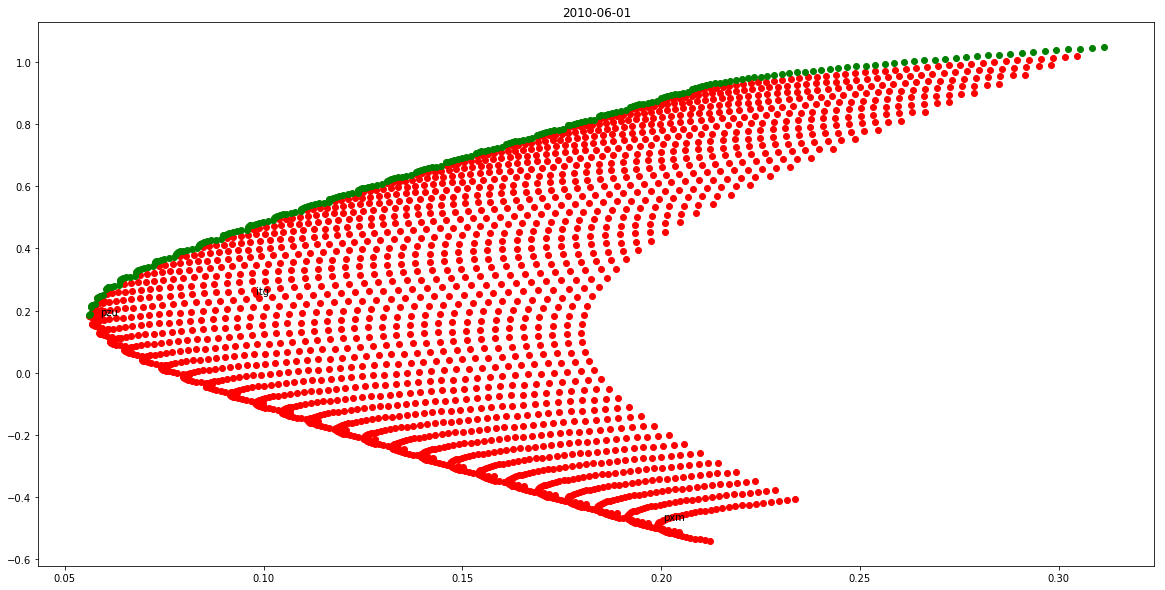

dict_keys(['pzu', 'pxm', 'itg'])
2012-01-01
0.837 0.020 0.143 | 0.057 0.254
0.878 0.020 0.102 | 0.058 0.259
0.837 -0.020 0.184 | 0.058 0.282
0.878 -0.020 0.143 | 0.058 0.287
0.918 -0.020 0.102 | 0.058 0.291
0.959 -0.020 0.061 | 0.059 0.296
1.000 -0.020 0.020 | 0.060 0.301
0.878 -0.061 0.184 | 0.060 0.314
0.918 -0.061 0.143 | 0.060 0.319
0.959 -0.061 0.102 | 0.060 0.324
1.000 -0.061 0.061 | 0.061 0.329
0.918 -0.102 0.184 | 0.063 0.347
0.959 -0.102 0.143 | 0.063 0.352
1.000 -0.102 0.102 | 0.064 0.357
0.918 -0.143 0.224 | 0.068 0.375
0.959 -0.143 0.184 | 0.068 0.380
1.000 -0.143 0.143 | 0.068 0.385
0.959 -0.184 0.224 | 0.073 0.408
1.000 -0.184 0.184 | 0.073 0.413
1.000 -0.224 0.224 | 0.079 0.440
1.000 -0.265 0.265 | 0.085 0.468
1.000 -0.306 0.306 | 0.092 0.496
1.000 -0.347 0.347 | 0.099 0.524
1.000 -0.388 0.388 | 0.107 0.552
1.000 -0.429 0.429 | 0.115 0.580
1.000 -0.469 0.469 | 0.123 0.608
1.000 -0.510 0.510 | 0.131 0.636
1.000 -0.551 0.551 | 0.139 0.664
1.000 -0.592 0.592 | 0.148 0.692
1

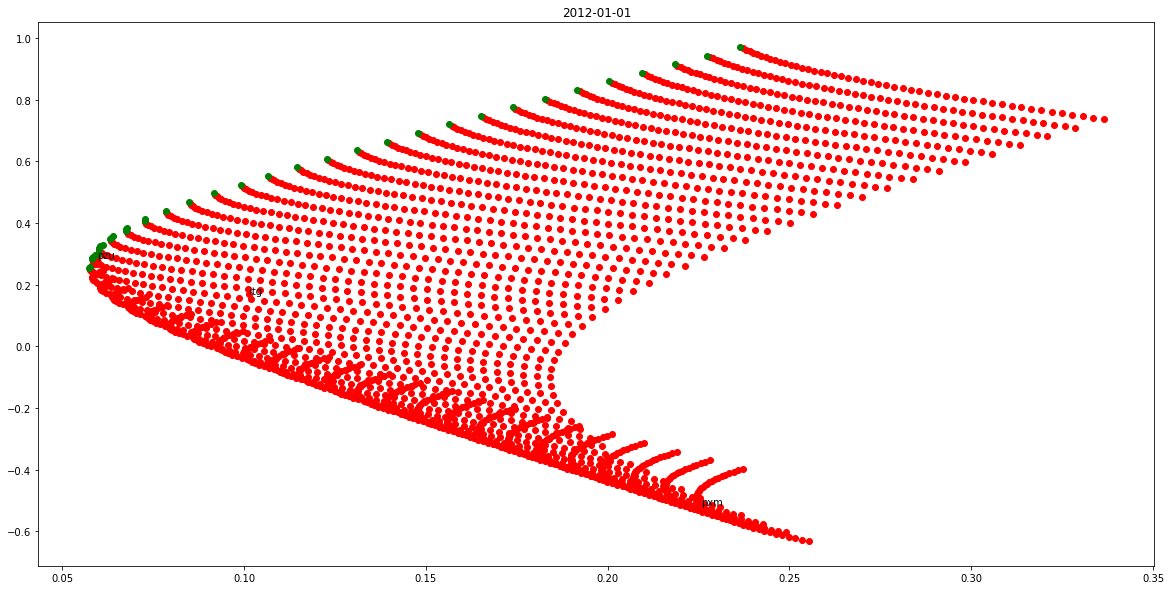

dict_keys(['pzu', 'pxm', 'itg'])
2013-01-01
0.837 0.020 0.143 | 0.058 0.134
0.878 0.020 0.102 | 0.058 0.142
0.878 -0.020 0.143 | 0.059 0.163
0.918 -0.020 0.102 | 0.059 0.172
0.959 -0.020 0.061 | 0.059 0.180
0.878 -0.061 0.184 | 0.060 0.185
0.918 -0.061 0.143 | 0.060 0.193
0.959 -0.061 0.102 | 0.061 0.201
1.000 -0.061 0.061 | 0.061 0.210
0.918 -0.102 0.184 | 0.062 0.215
0.959 -0.102 0.143 | 0.063 0.223
1.000 -0.102 0.102 | 0.063 0.231
0.918 -0.143 0.224 | 0.066 0.236
0.959 -0.143 0.184 | 0.066 0.244
1.000 -0.143 0.143 | 0.066 0.253
0.918 -0.184 0.265 | 0.070 0.257
0.959 -0.184 0.224 | 0.070 0.266
1.000 -0.184 0.184 | 0.070 0.274
0.959 -0.224 0.265 | 0.075 0.287
1.000 -0.224 0.224 | 0.075 0.295
0.959 -0.265 0.306 | 0.080 0.309
1.000 -0.265 0.265 | 0.080 0.317
0.959 -0.306 0.347 | 0.086 0.330
1.000 -0.306 0.306 | 0.086 0.338
1.000 -0.347 0.347 | 0.092 0.360
1.000 -0.388 0.388 | 0.099 0.381
1.000 -0.429 0.429 | 0.106 0.403
1.000 -0.469 0.469 | 0.113 0.424
1.000 -0.510 0.510 | 0.120 0.446
1

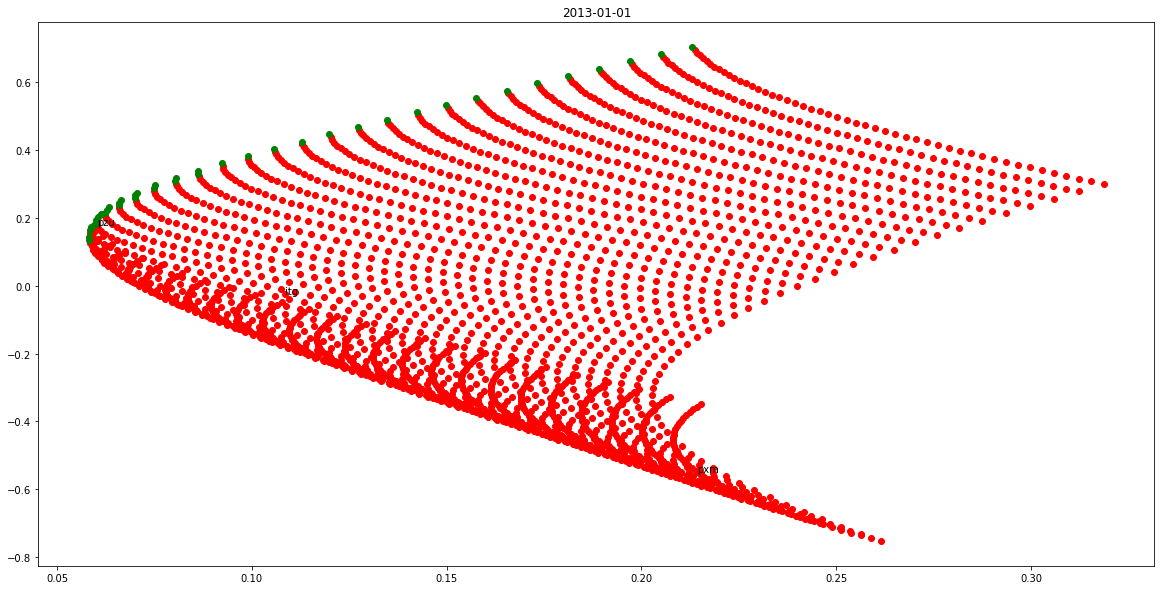

dict_keys(['pzu', 'pxm', 'itg'])
2014-01-01
0.837 0.224 -0.061 | 0.046 0.084
0.878 0.224 -0.102 | 0.047 0.112
0.918 0.224 -0.143 | 0.047 0.140
0.918 0.265 -0.184 | 0.047 0.143
0.959 0.224 -0.184 | 0.047 0.167
0.959 0.265 -0.224 | 0.048 0.170
1.000 0.184 -0.184 | 0.048 0.192
1.000 0.224 -0.224 | 0.048 0.195
1.000 0.265 -0.265 | 0.048 0.198
1.000 0.306 -0.306 | 0.049 0.201
1.000 0.347 -0.347 | 0.051 0.204
1.000 0.388 -0.388 | 0.053 0.207
1.000 0.429 -0.429 | 0.055 0.210
1.000 0.469 -0.469 | 0.057 0.213
1.000 0.510 -0.510 | 0.060 0.216
1.000 0.551 -0.551 | 0.063 0.219
1.000 0.592 -0.592 | 0.066 0.222
1.000 0.633 -0.633 | 0.070 0.225
1.000 0.673 -0.673 | 0.073 0.228
1.000 0.714 -0.714 | 0.077 0.231
1.000 0.755 -0.755 | 0.081 0.234
1.000 0.796 -0.796 | 0.085 0.237
1.000 0.837 -0.837 | 0.089 0.240
1.000 0.878 -0.878 | 0.093 0.243
1.000 0.918 -0.918 | 0.097 0.245
1.000 0.959 -0.959 | 0.101 0.248
1.000 1.000 -1.000 | 0.105 0.251


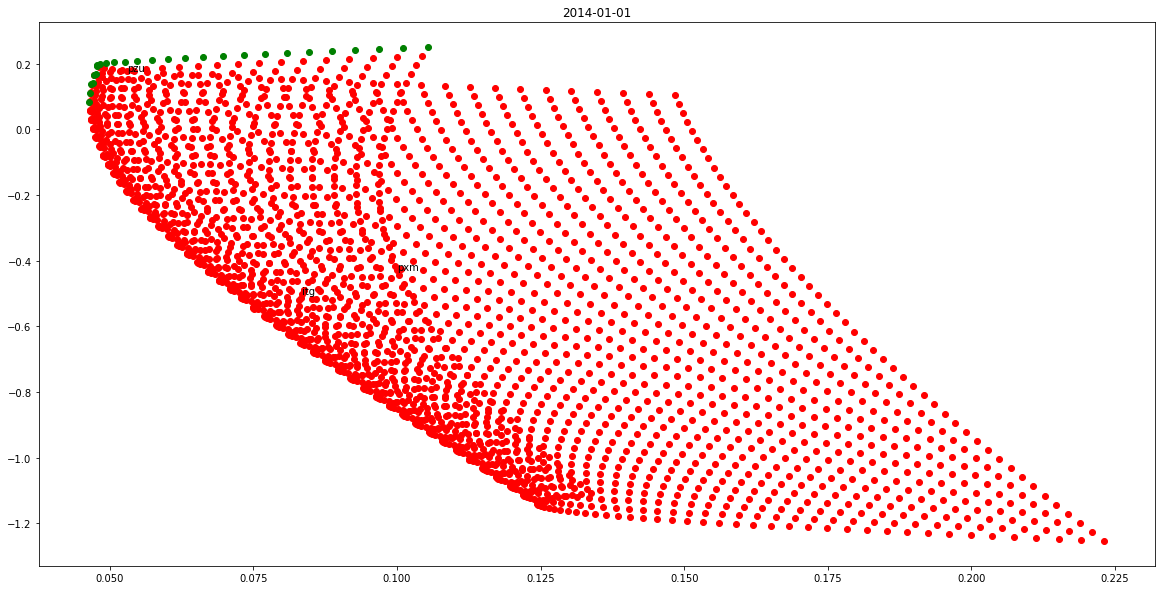

In [19]:
plot_density = 50

def portfolio_cmp(x):
    return (x[1][0], x[1][1])

for date in dates:
    optimal_portfolios_on_date = list(split_portfolios(calculate_portfolios_from_date(date, data_frames, plot_density))[0])
    print(date)
    optimal_portfolios_on_date.sort(key=portfolio_cmp)
    for port in optimal_portfolios_on_date:
        fmt_str = '{:.3f}'
        print(' '.join([fmt_str.format(k) for k in port[0]]) + ' | ' + ' '.join([fmt_str.format(k) for k in port[1]]))
    plot_portfolios_from_date(date, data_frames, plot_density)
    plt.show()